In [1]:
%load_ext autoreload
%autoreload 2

In [163]:
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torchvision.transforms import v2
from mini_yolov3.utils import draw_bounding_boxes, draw_grid
from torchvision.ops import box_convert
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
import torch
from torchvision.ops import box_convert
from mini_yolov3.model_output import YoloV3Output

In [42]:
dataset = SVHNDataset(split="train", 
                      image_transform=v2.Compose([
                        v2.ToTensor(),
                        v2.Resize((64, 64))  
                      ]))

/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [43]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [45]:
anchors = torch.Tensor([[0.2, 0.8]])

In [84]:
item = dataset[0]

In [147]:
for x in dataloader:
    print(x["bboxes"])
    print(box_convert(x["bboxes"][0], in_fmt="xywh", out_fmt="xyxy"))
    target = build_targets(
        bboxes=x["bboxes"],
        labels=x["labels"],
        anchors=anchors,
        grid_size=(2, 2),
        num_classes=10
    )

    break

[tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])]
tensor([[0.3551, 0.0217, 0.5514, 0.8913],
        [0.5327, 0.0652, 0.6822, 0.9348]])


In [78]:
target[0, :, 0, 0], target[0, :, 1, 1]

(tensor([-0.1875, -0.1744, -0.0189,  0.0834,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]),
 tensor([ -2.1168, -18.4207,  -0.2908,   0.0834,   1.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,
           0.0000]))

In [134]:
# construct mock pred
pred = torch.zeros((1, anchors.shape[0] * (5 + 10), 2, 2))

pred[0, :5, 0, 0] = target[0, :5 , 0, 0] # first cell
pred[0, 4 + 5, 0, 0] = 0.95 # class pred
pred[0, 4, 0, 0] = 0.9 # confidence
pred[0, :4, 0, 0] -= 0.1 # xywh
pred[0, :5, 1, 1] = target[0, :5, 1, 1] # second cell
pred[0, 4 + 7, 1, 1] = 0.98 # class pred
pred[0, 4, 1, 1] = 0.89 # confidence

pred.shape, pred[0, :, 0, 0], pred[0, :, 1, 1]

(torch.Size([1, 15, 2, 2]),
 tensor([-0.2875, -0.2744, -0.1189, -0.0166,  0.9000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.9500,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]),
 tensor([ -2.1168, -18.4207,  -0.2908,   0.0834,   0.8900,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.9800,   0.0000,   0.0000,
           0.0000]))

In [141]:
criterion = YOLOLoss(num_classes=10, anchors=anchors)

In [162]:
pred.requires_grad = True
criterion(pred, x["bboxes"], x["labels"])

tensor(0.1195, grad_fn=<AddBackward0>)

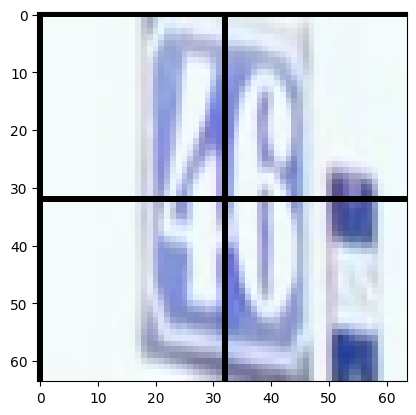

In [85]:
plt.imshow(draw_grid(item["image"], grid_size=64//2))

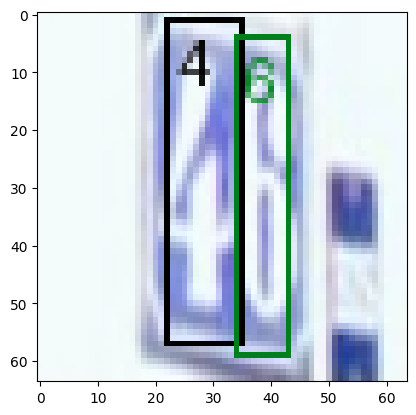

In [86]:
plt.imshow(
    draw_bounding_boxes(
        image=item["image"],
        bboxes=box_convert(item["bbox"], in_fmt="xywh", out_fmt="xyxy"),
        labels=item["labels"]
    )
)

In [187]:
a = torch.ones(1, 2, 2, 10)
b = torch.ones(1, 2, 2, 1)

(a + b)[0][:, :, 0]

tensor([[2., 2.],
        [2., 2.]])

In [188]:
output = YoloV3Output(pred, anchors, num_classes=10)

In [198]:
output.bounding_boxes()

[{'bboxes': tensor([[0.3398, 0.0384, 0.1776, 0.7868],
          [0.5327, 0.0652, 0.1495, 0.8696]], grad_fn=<StackBackward0>),
  'confidence': tensor([0.9000, 0.8900], grad_fn=<SelectBackward0>),
  'labels': tensor([4, 6])}]

In [191]:
0.4286 + 0.1776 /2

0.5174